In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None

# KREDİ TAHMİNİ VERİ SETİ

In [2]:
ds = pd.read_csv("D:\\train_kredi_tahmini.csv") #csv dosyasi okuma

VERİ SETİ ANALİZİ

In [3]:
ds.info()    #sutunlar hakkinde bilgi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
ds.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
ds.shape  #(kayit sayisi,sutun sayisi)

(614, 13)

In [6]:
ds.describe()   #numeric olan sutunların istatistiksel verileri

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


# PREPROCESS (ÖN İŞLEME AŞAMASI)

In [7]:
ds.duplicated().sum()   #tekrarlanan satır var mi kontrol

0

In [8]:
print(ds.isnull().sum()) #null olan hücre sayisi her bir sutun icin
print("Toplam Nan hucre sayisi : {}".format(ds.isnull().sum().sum()))  

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Toplam Nan hucre sayisi : 149


In [9]:
def missingValues(ds):
    missingValue=ds.isnull().sum()
    missingValuePercent=100*ds.isnull().sum()/len(ds)
    missingValueTab=pd.concat([missingValue,missingValuePercent],axis=1)
    missingValueTable=missingValueTab.rename(
    columns ={0:'Eksik Degerler',1:'% Degeri'})
    return missingValueTable

missingValues(ds)

,Eksik Degerler,% Degeri
Loan_ID,0,0.000000
Gender,13,2.117264
Married,3,0.488599
Dependents,15,2.442997
Education,0,0.000000
Self_Employed,32,5.211726
ApplicantIncome,0,0.000000
CoapplicantIncome,0,0.000000
LoanAmount,22,3.583062
Loan_Amount_Term,14,2.280130


EKSİK DEĞERLERİN KALDIRILMASI & DOLDURULMASI

In [10]:
ds_crop = ds.dropna(subset=["Gender","Married"])     #gender ve married verileri bos olan satirlar silindi

In [11]:
ds_crop[['Self_Employed']]=ds_crop[['Self_Employed']].replace('No',0)
ds_crop[['Self_Employed']]=ds_crop[['Self_Employed']].replace('Yes',1)

ds_crop[['Dependents']]=ds_crop[['Dependents']].replace('0',0)
ds_crop[['Dependents']]=ds_crop[['Dependents']].replace('1',1)
ds_crop[['Dependents']]=ds_crop[['Dependents']].replace('2',2)
ds_crop[['Dependents']]=ds_crop[['Dependents']].replace('3+',3)

ds_crop[['Loan_Status']]=ds_crop[['Loan_Status']].replace('N',0)
ds_crop[['Loan_Status']]=ds_crop[['Loan_Status']].replace('Y',1)
#Maskeleme yapiyorum. Ilgili sutun adlarındaki ilgili degerleri degistiriyorum boylece verileri numeric yapmis oluyorum

In [12]:
ds_fill=ds_crop.fillna(ds_crop.median()) #Nan hucreler median degere gore dolduruldu

In [13]:
missingValues(ds_fill)   #Nan veri kalmadi

,Eksik Degerler,% Degeri
Loan_ID,0,0.0
Gender,0,0.0
Married,0,0.0
Dependents,0,0.0
Education,0,0.0
Self_Employed,0,0.0
ApplicantIncome,0,0.0
CoapplicantIncome,0,0.0
LoanAmount,0,0.0
Loan_Amount_Term,0,0.0


In [14]:
ds_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            598 non-null    object 
 1   Gender             598 non-null    object 
 2   Married            598 non-null    object 
 3   Dependents         598 non-null    float64
 4   Education          598 non-null    object 
 5   Self_Employed      598 non-null    float64
 6   ApplicantIncome    598 non-null    int64  
 7   CoapplicantIncome  598 non-null    float64
 8   LoanAmount         598 non-null    float64
 9   Loan_Amount_Term   598 non-null    float64
 10  Credit_History     598 non-null    float64
 11  Property_Area      598 non-null    object 
 12  Loan_Status        598 non-null    int64  
dtypes: float64(6), int64(2), object(5)
memory usage: 65.4+ KB


VERİ TİPİ DÖNÜŞÜMÜ

In [15]:
ds_fill['Dependents'] = ds_fill['Dependents'].astype('int64')
ds_fill['Self_Employed'] = ds_fill['Self_Employed'].astype('int64')
ds_fill['CoapplicantIncome'] = ds_fill['CoapplicantIncome'].astype('int64')
ds_fill['LoanAmount'] = ds_fill['LoanAmount'].astype('int64')
ds_fill['Loan_Amount_Term'] = ds_fill['Loan_Amount_Term'].astype('int64')
ds_fill['Credit_History'] = ds_fill['Credit_History'].astype('int64')

In [16]:
ds_fill.shape  #(kayit sayisi,sutun sayisi)

(598, 13)

AYKIRI DEĞER BOXPLOT GRAFİKLERİ

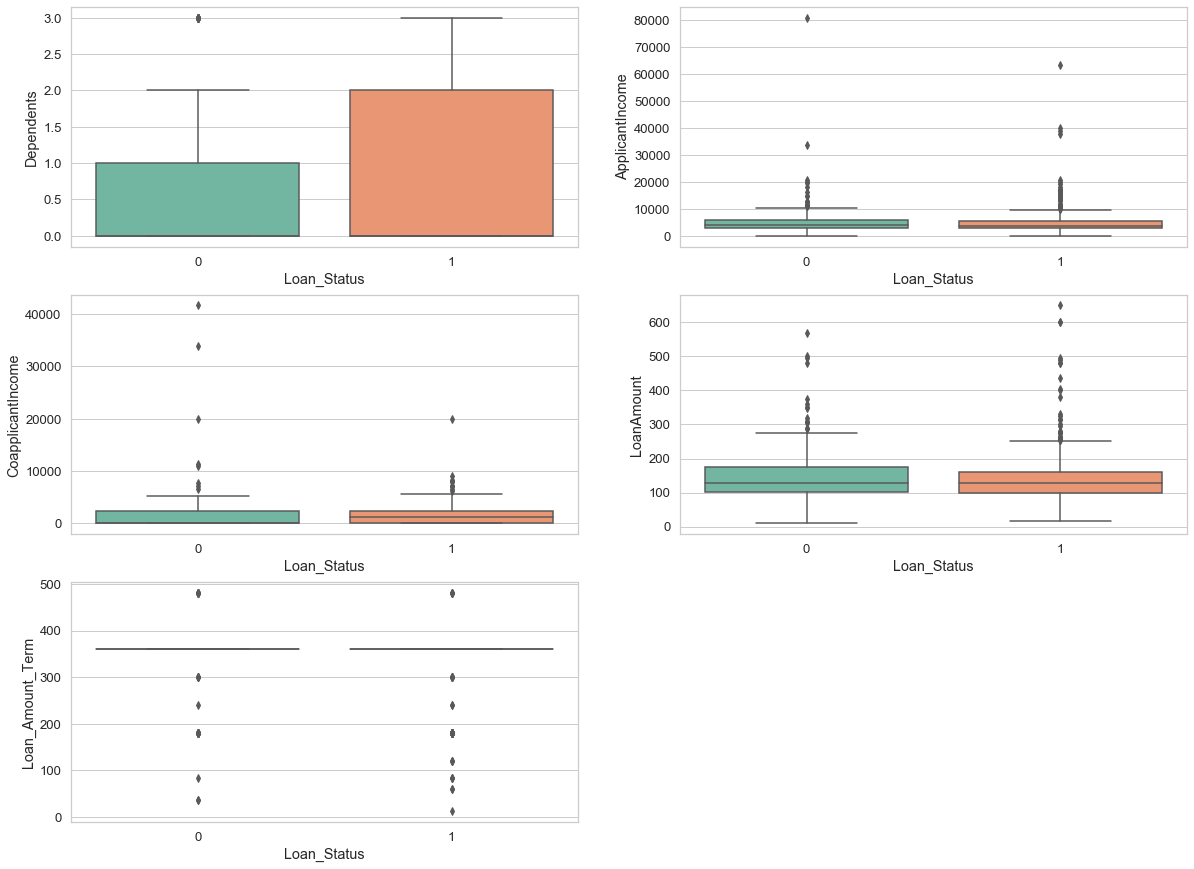

In [17]:
sns.set(style="whitegrid",font_scale=1.2,palette='Set2')
plt.subplots(figsize=(20,15))
plt.subplot(3,2,1)
sns.boxplot(x='Loan_Status', y='Dependents',data=ds_fill)
plt.subplot(3,2,2)
sns.boxplot(x='Loan_Status', y='ApplicantIncome',data=ds_fill)
plt.subplot(3,2,3)
sns.boxplot(x='Loan_Status', y='CoapplicantIncome',data=ds_fill)
plt.subplot(3,2,4)
sns.boxplot(x='Loan_Status', y='LoanAmount',data=ds_fill)
plt.subplot(3,2,5)
sns.boxplot(x='Loan_Status', y='Loan_Amount_Term',data=ds_fill)

VERİ SETİ DENGESİZLİĞİ KONTROLÜ

1    411
0    187
Name: Loan_Status, dtype: int64
1    0.687291
0    0.312709
Name: Loan_Status, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


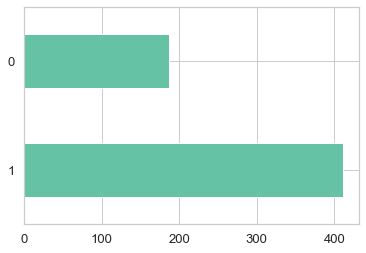

In [18]:
print(ds_fill['Loan_Status'].value_counts())
print(ds_fill['Loan_Status'].value_counts()/np.float(len(ds_fill)))
print(ds_fill['Loan_Status'].value_counts().plot.barh())

OVER-SAMPLING (SMOTE)

In [19]:
#Bağımsız değişkenler ve hedef değişkeni ayriliyor
features = ['Dependents','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History']
ds_x = ds_fill.loc[:,features]
ds_y = ds_fill.loc[:,['Loan_Status']]

smote = SMOTE()
X_sm, y_sm = smote.fit_sample(ds_x, ds_y)
print(X_sm.shape)
print(y_sm.shape)

(822, 7)
(822, 1)


1    411
0    411
Name: Loan_Status, dtype: int64
1    0.5
0    0.5
Name: Loan_Status, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


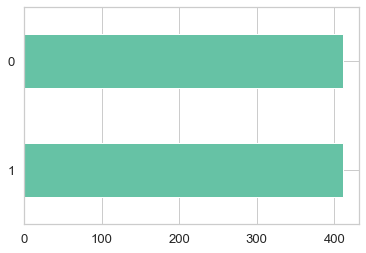

In [20]:
print(y_sm['Loan_Status'].value_counts())
print(y_sm['Loan_Status'].value_counts()/np.float(len(y_sm)))
print(y_sm['Loan_Status'].value_counts().plot.barh())

KORELASYON ANALİZİ

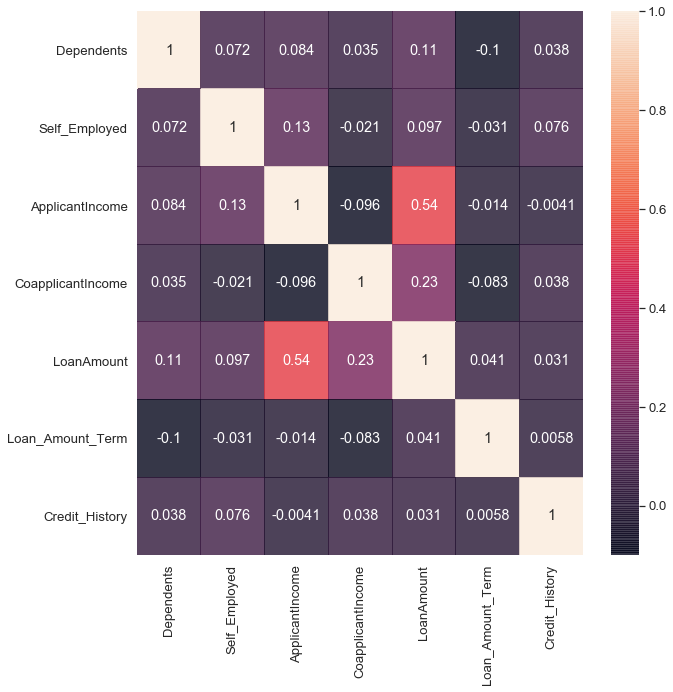

In [21]:
#korelasyona ait isi haritasi olusturumu haritada acik renk yuksek korelasyon
plt.figure(figsize=(10,10))
sns.heatmap(X_sm.corr(),annot=True,alpha=0.8)

STANDARDİZASYON

In [22]:
X_sm = StandardScaler().fit_transform(X_sm)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.4, random_state = 120)

# SINIFLANDIRMA ALGORİTMALARI

SVM ALGORİTMASI (SUPPORT VECTOR MACHINE/DESTEK VEKTÖR MAKİNELERİ)

In [24]:
svmModel = SVC(C=3,kernel="rbf").fit(X_train,y_train)
y_pred = svmModel.predict(X_test)
svmAccuracy = accuracy_score(y_test,y_pred)
svmAccuracy 

0.7993920972644377

[[110  61]
 [  5 153]]


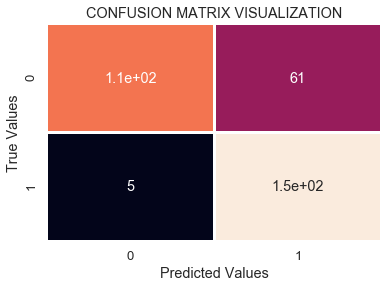

In [25]:
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,lw=2,cbar=False)
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("CONFUSION MATRIX VISUALIZATION")
plt.show()

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.64      0.77       171
           1       0.71      0.97      0.82       158

    accuracy                           0.80       329
   macro avg       0.84      0.81      0.80       329
weighted avg       0.84      0.80      0.79       329



NAIVE BAYES ALGORİTMASI

In [27]:
nb = GaussianNB()
nb_model = nb.fit(X_train, y_train)
nb_model.predict(X_test)
y_pred = nb_model.predict(X_test)
nbAccuracy = accuracy_score(y_test, y_pred)
nbAccuracy

0.7872340425531915

[[104  67]
 [  3 155]]


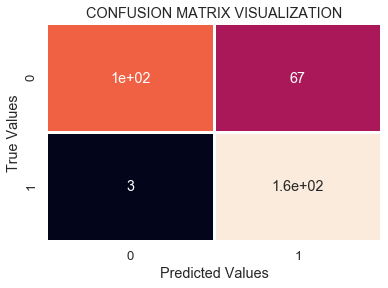

In [28]:
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,lw=2,cbar=False)
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("CONFUSION MATRIX VISUALIZATION")
plt.show()

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.61      0.75       171
           1       0.70      0.98      0.82       158

    accuracy                           0.79       329
   macro avg       0.84      0.79      0.78       329
weighted avg       0.84      0.79      0.78       329



KNN ALGORİTMASI (K-NEAREST NEIGHBOR/K-EN YAKIN KOMŞU)

In [30]:
knnModel = KNeighborsClassifier(n_neighbors =7).fit(X_train,y_train)
y_pred = knnModel.predict(X_test)
knnAccuracy = accuracy_score(y_test,y_pred)
knnAccuracy

0.8024316109422492

[[117  54]
 [ 11 147]]


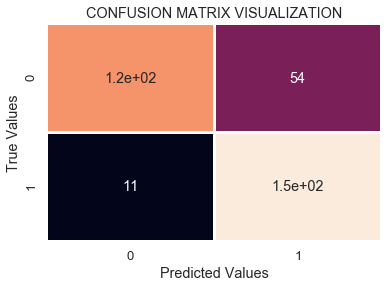

In [31]:
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,lw=2,cbar=False)
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("CONFUSION MATRIX VISUALIZATION")
plt.show()

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.68      0.78       171
           1       0.73      0.93      0.82       158

    accuracy                           0.80       329
   macro avg       0.82      0.81      0.80       329
weighted avg       0.83      0.80      0.80       329



RANDOM FOREST ALGORİTMASI

In [33]:
rf_model = RandomForestClassifier(max_features=5,
                                min_samples_split=2,
                                n_estimators=1000)
rf_tuned=rf_model.fit(X_train,y_train)
y_pred = rf_tuned.predict(X_test)
rfAccuracy  = accuracy_score(y_test,y_pred)
rfAccuracy

0.8449848024316109

[[134  37]
 [ 14 144]]


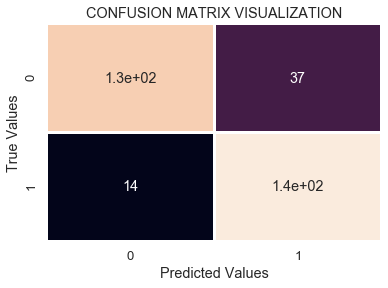

In [34]:
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,lw=2,cbar=False)
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("CONFUSION MATRIX VISUALIZATION")
plt.show()

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84       171
           1       0.80      0.91      0.85       158

    accuracy                           0.84       329
   macro avg       0.85      0.85      0.84       329
weighted avg       0.85      0.84      0.84       329



In [36]:
pd.DataFrame([["SVM",svmAccuracy],["NB",nbAccuracy],["KNN",knnAccuracy],["RF",rfAccuracy]],columns=["Model","Accuracy"])

,Model,Accuracy
0,SVM,0.799392
1,NB,0.787234
2,KNN,0.802432
3,RF,0.844985
